### Basic ISC



#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob,shutil
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Load timeseries, run basic ISC (static)

In [2]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')
sub_list = list(np.hstack((twin_df['twin_A_id'].values, twin_df['twin_B_id'].values)))
len(sub_list)

200

In [3]:
# done only for the 1st time, later just load the data
'''
ts_data = []

for curr_sub in sub_list:
    #print(curr_sub)
    curr_file = '../data/03_extract_ts/' + curr_sub + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
    #print(curr_file)
    
    ts_data.append(np.load(curr_file))
    
ts_data = np.asarray(ts_data)
print(ts_data.shape)

np.save('../data/03_extract_ts/ts_array_shen268_pauli16_aan9.npy', ts_data)
#'''
print(' ')

In [4]:
# load timeseries, swap axes
ts_array = np.load('../data/03_extract_ts/ts_array_shen268_pauli16_aan9.npy')
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
ts_data.shape

(380, 293, 200)

In [5]:
# submit to ISC analysis
# takes about 15-20 minutes on normal machine
ISC, p, distribution = partly_phaseshift_isc(ts_data, 
                                           pairwise= False,
                                           summary_statistic = np.mean,
                                           n_shifts = 1,#000, #can reduce to speed up, better increase to 1000
                                           return_distribution=True)

ISC[np.isnan(ISC)] = 0

# Stats correction (uncomment if you computed enough n_shifts)
alpha                           = .05
q                               = multipletests(p[0, :], method='fdr_by')[1]
corrected                       = q[np.newaxis, :] < alpha
#ISC[corrected == False]         = 0

isc_result_dict                 = {}
isc_result_dict['ISC']          = ISC
isc_result_dict['p']            = p
isc_result_dict['distribution'] = distribution

#### Plot ISC results

<Figure size 1440x1080 with 0 Axes>

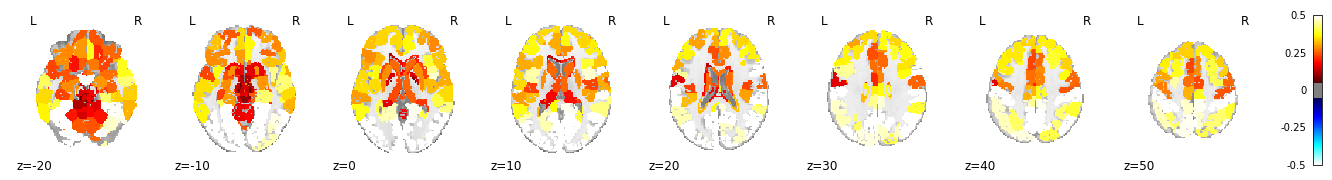

In [6]:
all293_rois_file  = '../data/02_rois_masks_maps/allcombined.nii'
all293_masker     = input_data.NiftiLabelsMasker(all293_rois_file);

all293_masker.fit('../data/02_rois_masks_maps/sub-0001_ses-02_task-partlycloudy_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

curr_isc = np.reshape(ISC, (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);
plt.figure(figsize = (20,15));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold      = 0.05, 
                                   vmax           = 0.50, 
                                   draw_cross     = True,
                                   display_mode   = 'z',
                                   cut_coords     = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   symmetric_cbar = True,
                                   annotate       = True,);

plt.show();

In [7]:
oldstudy_isc = np.load('../data/99_other/oldstudy_isc.npy')
print(oldstudy_isc.shape)

curr_isc_shen = curr_isc[:, :268]
print(curr_isc_shen.shape)

(1, 268)
(1, 268)


In [8]:
np.corrcoef(oldstudy_isc, 
           curr_isc_shen)

array([[1.        , 0.86879712],
       [0.86879712, 1.        ]])

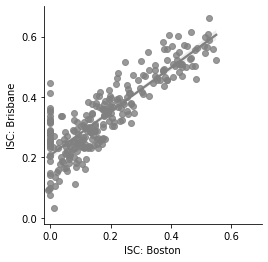

In [22]:
sns.regplot(oldstudy_isc, 
            curr_isc_shen,
            color = 'gray')
plt.axis('square');
plt.xlim(-0.02,.7);
plt.ylim(-0.02,.7);

plt.xticks(ticks=[0, .2,.4,.6])
plt.yticks(ticks=[0, .2,.4,.6])

plt.xlabel('ISC: Boston')
plt.ylabel('ISC: Brisbane')
sns.despine()

### Conclusion

We find robust ISC across the groups of viewers. 

While (imo) not very surprising, this is affirming.

Moreover, the cortical distribution of ISC mirrors that of the previous study. 

Thus provides solid grounds to examine more fine-grained questions, particularly ISC between twins in the following notebooks.


In [24]:
ts_data.shape

(380, 293, 200)

In [26]:
old_data = np.load('../data/99_other/old_study_ts_array_shen268_regional_average_ages13-99.npy')
old_data = np.swapaxes(old_data, 0, 2)
old_data = np.swapaxes(old_data, 0, 1)
old_data.shape

(168, 268, 33)

In [30]:
old_data1 = np.mean(old_data[:,:,:16], axis =2)
old_data2 = np.mean(old_data[:,:,16:], axis =2)

curr_data1 = np.mean(ts_data[:,:,:100], axis =2)
curr_data2 = np.mean(ts_data[:,:,100:], axis =2)

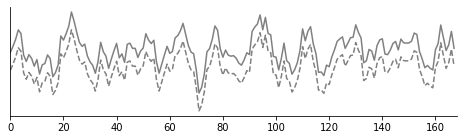

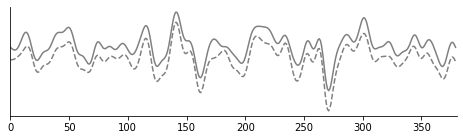

In [75]:
curr_region = 47

plt.figure(figsize = (8,2))
plt.plot(old_data1[:, curr_region], color = 'gray', linestyle = 'dashed')
plt.plot(old_data1[:, curr_region]+0.5, color = 'gray')
plt.xlim([0, 168])
plt.yticks([])

sns.despine()


plt.figure(figsize = (8,2))
plt.plot(curr_data1[:, curr_region], color = 'gray', linestyle = 'dashed')
plt.plot(curr_data2[:, curr_region]+0.5, color = 'gray')
plt.xlim([0, 380])
plt.yticks([])
sns.despine()
